In [16]:
import os
import torch
import wandb
import rasterio
import logging

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
import pandas as pd

from glob import glob
from codecarbon import EmissionsTracker
from tqdm.notebook import tqdm
from argparse import ArgumentParser
from represent.datamodules.uc4_cloud_detection import UC4CloudDetectionDataModule, UC4CloudDetectionDataset
from represent.models.uc4_resnet import UC4ResNet
from represent.callbacks.delayed_unfreeze import DelayedUnfreeze
from represent.models.moco import DualMoco
from represent.transforms.augmentations import get_data_augmentation
from represent.tools.utils import seed_all
from represent.tools.plots import plot_img_grid

from pl_bolts.models.regression import LogisticRegression
from pytorch_lightning.loggers import WandbLogger
from datetime import datetime

from tqdm.notebook import tqdm

torch.backends.cudnn.benchmark = True
logger = logging.getLogger()
logger.setLevel(logging.WARNING)


In [17]:
config = dict(
    # DataModule Settings
    data_dir = "/data/lloyd/RepreSent/UC4/WHUS2-CD+/prepared/output/",
    seed = 42,
    batch_size = 4,
    num_workers = 16,
    training_set_fraction = 0.70,
    limit_dataset = 0.5,
    patch_size = 256,
    
    # Trainer Settings
    gpus = 1,
    accelerator="gpu",
    strategy = None,
    
    # Model Parameters
    use_mlp = False,
    num_classes = 1,
    input_ch = 13,
    backbone = "resnet18",
    segmentation = True,
    checkpoint = "represent/represent/weights/moco_resnet18.pth",
    
    # Optimizer Parameteres
    optimizer = "Adam",
    scheduler = "CosineAnnealingLR",
    momentum = 0.9,
    max_epochs = 50,
    learning_rate = 2e-2,
)

parser = ArgumentParser()
parser = pl.Trainer.add_argparse_args(parser)
parser = UC4ResNet.add_model_specific_args(parser)
parser = UC4CloudDetectionDataModule.add_model_specific_args(parser)

args, arg_strings = parser.parse_known_args([], None)
for key, value in config.items():
    setattr(args, key, value)

seed_all(config['seed'])

Global seed set to 42


In [3]:
wandb.finish()
ts = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
run_name = f"UC4_ResNet_{ts}"
logger = WandbLogger(project="RepreSent_UC4", name=run_name, log_model=True, save_code=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hughes-lloyd. Use `wandb login --relogin` to force relogin


In [3]:
uc4_datamodule = UC4CloudDetectionDataModule.from_argparse_args(args,)

In [18]:
# args.classification_head = torch.nn.Linear(512, config['num_classes'])
args.classification_head = torch.nn.Sequential(
    torch.nn.Conv2d(512, 64, kernel_size=3, padding=1),
    torch.nn.InstanceNorm2d(64),
    torch.nn.ReLU(),
    torch.nn.Conv2d(64, config['num_classes'], kernel_size=1)
)

model = UC4ResNet(**args.__dict__)

# Load MoCo weights
Load the MoCo weights and remap the names to match a standard ResNet implementation

In [5]:
if 'checkpoint' in config:
    model.load_from_checkpoint(config['checkpoint'], filter_and_remap="s2_moco.encoder_q")

/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/torch/cuda/__init__.py:106: UserWarning: 
NVIDIA GeForce RTX 3090 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3090 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


# Finetune the model

In [7]:
checkpointer = pl.callbacks.ModelCheckpoint(
    dirpath=f'checkpoints/UC2_MoCo/{run_name}',
    filename="{epoch}-{val_acc:.2f}",
    monitor="val_acc",
    mode="max",
    save_last=True,
)

early_stopping_callback = pl.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=15)

unfreezer = DelayedUnfreeze(backbone_id="model", unfreeze_at_epoch=5, train_frozen_bn=True, reset_lr=7e-3)

callbacks = [checkpointer, early_stopping_callback, unfreezer]

# for p in model.model.parameters():
#     p.requires_grad = False

In [8]:
trainer = pl.Trainer.from_argparse_args(args, enable_checkpointing=True, 
                                        logger=logger, callbacks=callbacks, 
                                        auto_lr_find=False)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
try:
    run = trainer.fit(model, datamodule=uc4_datamodule)
finally:
    wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type               | Params
--------------------------------------------------------
0 | model            | ResNet             | 11.2 M
1 | classifier       | Sequential         | 295 K 
2 | iou_metric_train | BinaryJaccardIndex | 0     
3 | iou_metric_val   | BinaryJaccardIndex | 0     
4 | oa_train         | BinaryAccuracy     | 0     
5 | oa_val           | BinaryAccuracy     | 0     
--------------------------------------------------------
304 K     Trainable params
11.2 M    Non-trainable params
11.5 M    Total params
46.012    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/home/lloyd/anaconda3/envs/epfl/lib/python3.8/site-packages/pytorch_lightning/callbacks/finetuning.py:210: UserWarning: The provided params to be frozen already exist within another group of this optimizer. Those parameters will be skipped.
HINT: Did you init your optimizer in `configure_optimizer` as such:
 <class 'torch.optim.adam.Adam'>(filter(lambda p: p.requires_grad, self.parameters()), ...) 
  rank_zero_warn(


# Find Learning Rate

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Learning rate set to 0.052480746024977286
Restoring states from the checkpoint path at /home/lloyd/Documents/Experiments/RepreSent/.lr_find_dac607f3-29df-4cd5-8893-59bcc14cdf7b.ckpt


0.052480746024977286

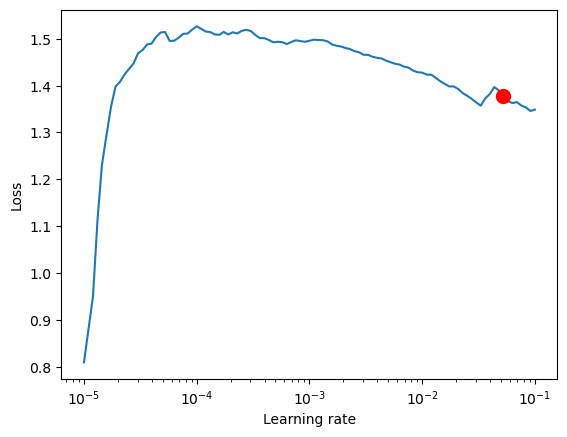

In [9]:
trainer_lr = pl.Trainer.from_argparse_args(args, enable_checkpointing=False, logger=None, auto_lr_find=True)

lr_finder = trainer_lr.tune(model, datamodule=uc4_datamodule, lr_find_kwargs={"min_lr": 1e-7, "max_lr": 1e-1,})

fig=lr_finder['lr_find'].plot(suggest=True)
fig.show()
lr_finder['lr_find'].suggestion()

# Evaluate the Model

In [19]:
from glob import glob

# import wandb
# run = wandb.init()
# artifact = run.use_artifact('hughes-lloyd/RepreSent_UC4/model-3fwbzida:v0', type='model')
# artifact_dir = artifact.download()

# checkpoint = os.path.join(artifact_dir, "model.ckpt")
checkpoint = "represent/represent/weights/uc4_moco_resnet18.pth"
# idx = -5
# checkpoints = glob(f"checkpoints/UC5ResNet/*/*.ckpt")
# checkpoint = checkpoints[idx]
# print("Using checkpoint ", checkpoint) 
# checkpoint = "represent/represent/weights/uc5_moco_resnet18_4px.pth"

model = UC4ResNet(**args.__dict__)
model.load_state_dict(torch.load(checkpoint)['state_dict'], strict=True)

# model.load_from_checkpoint(checkpoint)
# model.classifier.load_state_dict(torch.load(checkpoint)['state_dict'], strict=False)
# model.load_from_checkpoint(checkpoint, filter_and_remap="streams.0.", stream_id=0)
# model.load_from_checkpoint(checkpoint, filter_and_remap="streams.1.", stream_id=1, input_ch_subset=s2_bands)

model = model.to('cuda')
model = model.eval()

In [224]:
from tqdm.notebook import tqdm
from represent.datamodules.uc4_cloud_detection import UC4CloudDetectionDataModule, UC4CloudDetectionDataset
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryJaccardIndex

args.batch_size = 8
datamodule = UC4CloudDetectionDataModule.from_argparse_args(args,)

datamodule.setup(stage="test")

preds = []
targets = []

metrics = MetricCollection([
    BinaryAccuracy(),
    BinaryPrecision(),
    BinaryRecall(),
    BinaryF1Score(),
    BinaryJaccardIndex(),
]).to("cuda")

# c = 0
# with torch.no_grad():
#     for batch in tqdm(datamodule.test_dataloader()):
#         x, y_true = batch
#         x, y_true = x.to('cuda'), y_true.to('cuda')
#         y_pred = model(x)
#         p_pred = torch.sigmoid(y_pred)
#         metrics(p_pred, y_true)
        
#         if y_true.sum() > 2000:
#             break

In [9]:
metrics.compute()

{'BinaryAccuracy': tensor(0.9604, device='cuda:0'),
 'BinaryPrecision': tensor(0.7916, device='cuda:0'),
 'BinaryRecall': tensor(0.7223, device='cuda:0'),
 'BinaryF1Score': tensor(0.7554, device='cuda:0'),
 'BinaryJaccardIndex': tensor(0.6069, device='cuda:0')}

In [20]:
def plot_result(binary_labels, binary_predictions):
    TP = np.logical_and(binary_labels == 1, binary_predictions == 1)
    TN = np.logical_and(binary_labels == 0, binary_predictions == 0)
    FP = np.logical_and(binary_labels == 0, binary_predictions == 1)
    FN = np.logical_and(binary_labels == 1, binary_predictions == 0)

    # Create an empty RGB image
    h, w = binary_labels.shape
    error_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Set the color for each type of error and correct classification
    # Red: Commission errors (FP)
    # Green: Omission errors (FN)
    # Blue: No errors (TP + TN)
    error_image[FP] = [255, 0, 0]  # Red for commission errors
    error_image[FN] = [0, 255, 0]  # Green for omission errors
    error_image[TP] = [255, 255, 255]  # White for cloudy pixels
    error_image[TN] = [134, 216, 247] # Blue for background pixels 

    # Plot the result
    plt.imshow(error_image)
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.show()

In [22]:
args_test = args
args_test.patch_size = 256
datamodule = UC4CloudDetectionDataModule.from_argparse_args(args_test,)
datamodule.setup("test")
dset = datamodule.test_dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

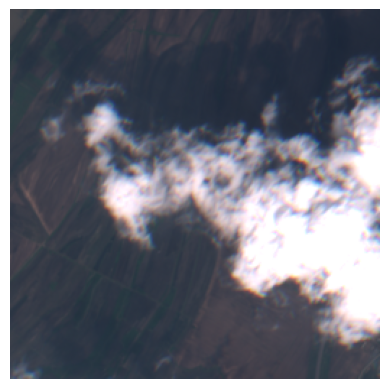

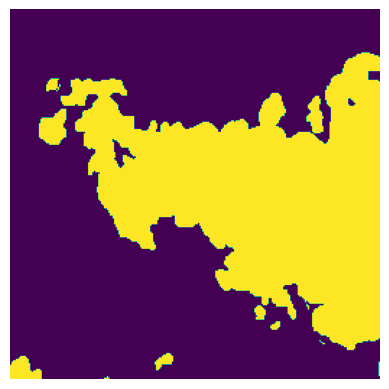

In [23]:
img2, lbl2 = dset[2133]

plt.figure()
plt.imshow(img2.numpy().transpose(1,2,0)[:,:,(3,2,1)]*2)
plt.axis("off")
plt.figure()
plt.imshow(lbl2.numpy().transpose(1,2,0))
plt.axis("off")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


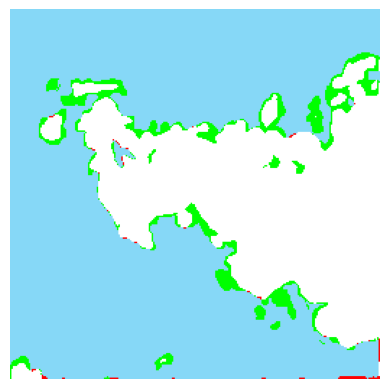

In [24]:
def infer_patch(model, img_patch_t):
    with torch.no_grad():
        img_t = torch.from_numpy(img_patch_t.numpy()[np.newaxis,]).to("cuda")
        o = model(img_t).to('cpu')
    return torch.sigmoid(o)
    
plt.figure()
plt.imshow(img2.numpy().transpose(1,2,0)[:,:,(3,2,1)]*2)
plt.imshow(infer_patch(model, img2)[0,].numpy().transpose(1,2,0)>0.5, alpha=0.5)
plt.axis("off")


pred = infer_patch(model, img2)[0,0,].numpy()>0.5
gt = lbl2.numpy()[0,]

plot_result(gt, pred)

# Full Scene

In [51]:
from scipy.ndimage import zoom

# WHUS2_CD_REMAP = (10, 0, 1, 2, 4, 5, 6, 3, 7, 11, 12, 8, 9) #Natural
WHUS2_CD_REMAP = (10, 2, 1, 0, 4, 5, 6, 3, 11, 8, 12, 9, 7) # MOCO
# WHUS2_CD_REMAP = (10, 0, 1, 2, 4, 5, 6, 3, 9, 11, 12, 7, 8) # DeepCluster
# WHUS2_CD_REMAP = (10, 2, 1, 0, 4, 5, 6, 3, 11, 12, 8, 9, 7) #8A last

SCENE_NAME = "S2A_MSIL1C_20190602T021611_N0207_R003_T52TES_20190602T042019"

imgs = []
band_names = []
annotation = None
sota = None

with rasterio.open(f"/data/lloyd/RepreSent/UC4/CDFM3SF_Masks/{SCENE_NAME}.tif") as src:
    sota = src.read(1).astype(np.float32)//255
    
with rasterio.open(f"/data/lloyd/RepreSent/UC4/WHUS2-CD+/unziped/ReferenceMask/{SCENE_NAME}_Mask.tif") as src:
    annotation = src.read(1).astype(np.float32)//255
    
with rasterio.open(f'/data/lloyd/RepreSent/UC4/WHUS2-CD+/{SCENE_NAME}.zip') as s2a:
    subdatasets = s2a.subdatasets
    
    r10m = rasterio.open(subdatasets[0])
    r20m = rasterio.open(subdatasets[1])
    r60m = rasterio.open(subdatasets[2])
    
    imgs.append(r10m.read().astype(np.float32))
    imgs.append(zoom(r20m.read().astype(np.float32), (1, 2, 2), order=0, mode="nearest", grid_mode=True))
    imgs.append(zoom(r60m.read().astype(np.float32), (1, 6, 6), order=0, mode="nearest", grid_mode=True))
    
    band_names.append([b.split(',')[0] for b in r10m.descriptions])
    band_names.append([b.split(',')[0] for b in r20m.descriptions])
    band_names.append([b.split(',')[0] for b in r60m.descriptions])

img = np.concatenate(imgs, axis=0)[
            WHUS2_CD_REMAP,
        ]
img = img.astype(np.float32) / 10000

In [52]:
patch_sz = 256
ch, row, col = img.shape

map_biomass = np.zeros((row, col))

with torch.no_grad():
    for r in tqdm(range(0, row, patch_sz-16)):
        for c in range(0, col, patch_sz-16):
#             patch = stack.isel(y=slice(r, r+patch_sz), x=slice(c, c+patch_sz)).load().data
            patch = img[:, slice(r, r+patch_sz), slice(c, c+patch_sz)].copy()
            patch = patch[np.newaxis, ]
            
            s2p = torch.from_numpy(patch).to("cuda")
            y_pred = model(s2p).to('cpu')
            
            y_pred = torch.sigmoid(y_pred)[0,].numpy().transpose(1,2,0)

            map_biomass[slice(r, r+patch_sz), slice(c, c+patch_sz)] = y_pred[:,:,0]
            

  0%|          | 0/46 [00:00<?, ?it/s]

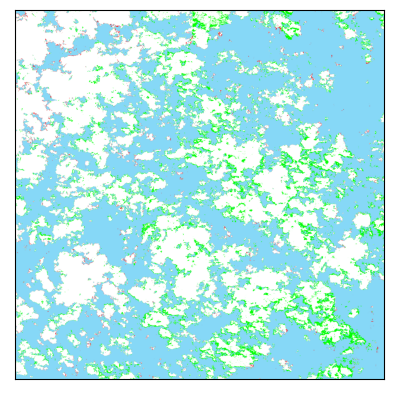

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 4999.5, 4999.5, -0.5)

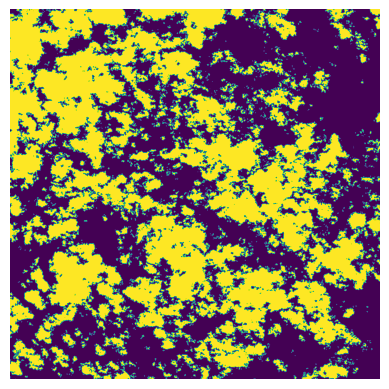

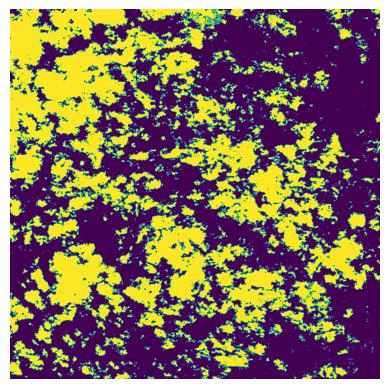

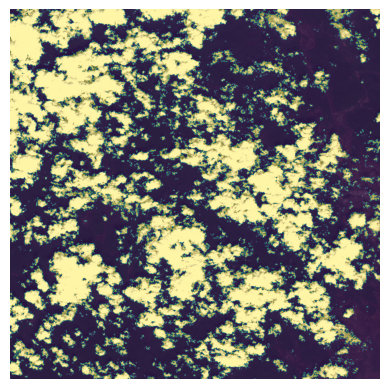

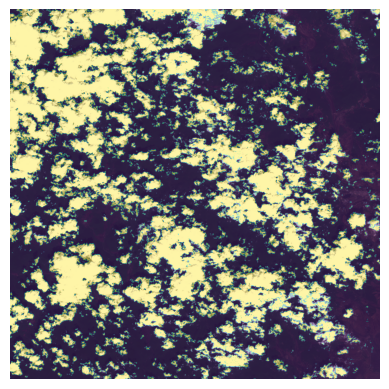

In [56]:
t = 0.1

s1 = slice(0, 5000)
s2 = slice(0, 5000)
plot_result(annotation[s1, s2], map_biomass[s1, s2]>t)


plt.figure()
plt.imshow(annotation[s1, s2])
plt.axis("off")
plt.figure()
plt.imshow(map_biomass[s1, s2]>t)
plt.axis("off")
plt.figure()
plt.imshow(img.transpose(1,2,0)[s1, s2,(3,2,1)]*2)
plt.imshow(annotation[s1, s2], alpha=0.4)
plt.axis("off")

plt.figure()
plt.imshow(img.transpose(1,2,0)[s1, s2,(3,2,1)]*2)
plt.imshow(map_biomass[s1, s2]>t, alpha=0.4)
plt.axis("off")

